In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV
import cv2
import mediapipe as mp
import joblib
import pickle

# **Data Loading**



In [2]:
#load the dataset
data = pd.read_csv('hand_landmarks_data.csv')
data.head()

,x1,y1,z1,x2,y2,z2,x3,y3,z3,x4,...,x19,y19,z19,x20,y20,z20,x21,y21,z21,label
0,262.669968,257.304901,-3.649205e-07,257.417542,247.109055,0.004224,246.882957,241.716827,0.005798,236.384537,...,223.345093,255.490692,-0.020450,215.043365,258.114746,-0.024577,208.006393,259.608673,-0.026722,call
1,83.351778,346.059113,-2.345265e-07,81.925037,328.562347,-0.011102,90.080132,311.535248,-0.021096,95.641823,...,132.451618,341.794434,-0.038175,142.773582,342.829254,-0.037336,152.431698,343.015991,-0.036136,call
2,187.756977,260.235492,-2.417307e-07,195.460579,241.506035,-0.000184,207.259529,223.674339,-0.009687,215.413628,...,250.301010,268.602938,-0.044068,262.425133,271.276638,-0.040469,272.989952,272.272231,-0.038301,call
3,114.976696,331.594238,-1.233261e-07,114.503494,320.549957,-0.002824,116.636627,310.080994,-0.008911,117.685066,...,145.195450,329.357544,-0.027622,151.053200,329.712341,-0.027863,155.990364,329.548828,-0.027723,call
4,188.795288,141.727867,-1.622995e-07,188.520905,127.947464,-0.002884,191.982880,111.010563,-0.008115,192.552521,...,226.696396,132.263248,-0.025113,234.831741,130.684147,-0.024087,241.587769,128.477188,-0.023486,call


# **Data Exploration**


In [3]:
# check nulls & data formats
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25675 entries, 0 to 25674
Data columns (total 64 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x1      25675 non-null  float64
 1   y1      25675 non-null  float64
 2   z1      25675 non-null  float64
 3   x2      25675 non-null  float64
 4   y2      25675 non-null  float64
 5   z2      25675 non-null  float64
 6   x3      25675 non-null  float64
 7   y3      25675 non-null  float64
 8   z3      25675 non-null  float64
 9   x4      25675 non-null  float64
 10  y4      25675 non-null  float64
 11  z4      25675 non-null  float64
 12  x5      25675 non-null  float64
 13  y5      25675 non-null  float64
 14  z5      25675 non-null  float64
 15  x6      25675 non-null  float64
 16  y6      25675 non-null  float64
 17  z6      25675 non-null  float64
 18  x7      25675 non-null  float64
 19  y7      25675 non-null  float64
 20  z7      25675 non-null  float64
 21  x8      25675 non-null  float64
 22

There is no null values and all data are exist in the required format

In [28]:
#check for duplicates
data.duplicated().sum()

np.int64(0)

There is no duplicates on data

# **Data Visualization**

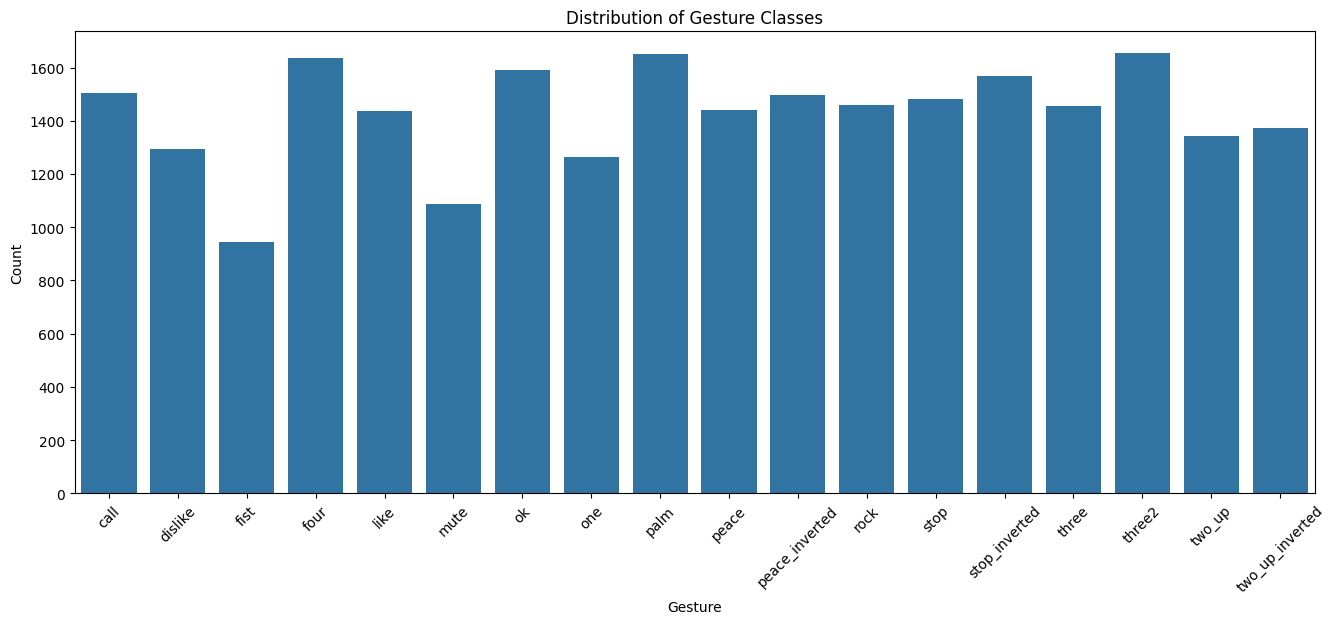

In [31]:
# Check if data is balanced or not ?
plt.figure(figsize=(16, 6))
sns.countplot(x=data['label'])
plt.title('Distribution of Gesture Classes')
plt.xlabel('Gesture')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


After visualizing the distribution of gesture classes, we observe that the dataset is nearly balanced.

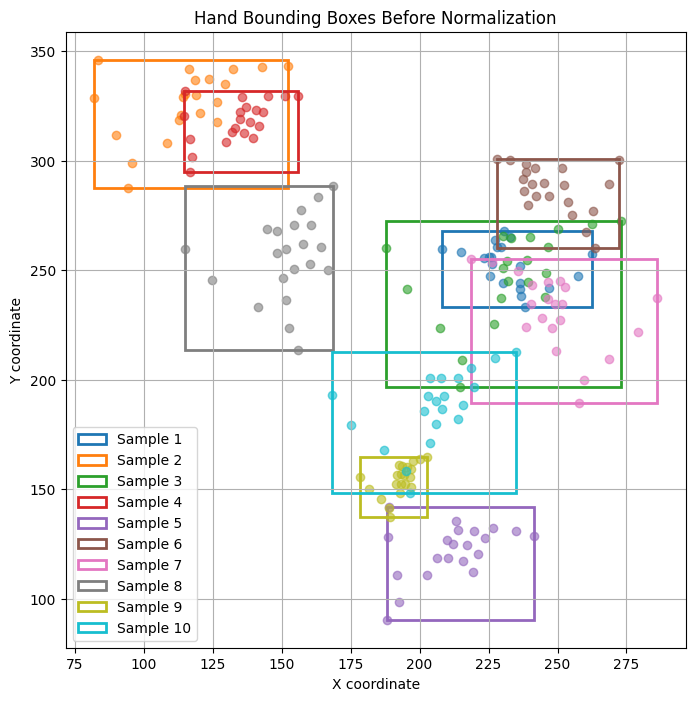

In [33]:
# Check if data points are in the same scale or not ?
num_samples = 10
x_cols = [f'x{i}' for i in range(1, 22)]
y_cols = [f'y{i}' for i in range(1, 22)]

plt.figure(figsize=(8, 8))

# Loop through the first 5 samples
for i in range(min(num_samples, len(data))):
    x = data.iloc[i][x_cols].values
    y = data.iloc[i][y_cols].values

    # Calculate bounding box corners
    xmin, xmax = x.min(), x.max()
    ymin, ymax = y.min(), y.max()

    # Draw rectangle and scatter points
    plt.gca().add_patch(
        plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                      fill=False, edgecolor=f'C{i}', linewidth=2, label=f'Sample {i+1}')
    )
    plt.scatter(x, y, color=f'C{i}', alpha=0.6)

plt.title('Hand Bounding Boxes Before Normalization')
plt.xlabel('X coordinate')
plt.ylabel('Y coordinate')
plt.legend()
plt.grid(True)
plt.show()


After plotting the bounding boxes for multiple hand samples, we observe a clear variation in scale across different hand instances.
This indicates that:

*   The hands in the dataset appear at different scales, meaning some hands are much larger or smaller than others.
*   This variation could be due to differences in camera distance, hand positioning, or subject differences (e.g., adults vs. children).

so we will need to apply normalization by scaling all hand landmarks based on wrist-to-mid-finger distance.



# **Data Preproccesing**

In [3]:
#Data Splitting
features = data.drop(['label'] , axis= 1)
labels = data[['label']]

#split the data into train and test 70% and 30%
features_train ,features_dev_test ,labels_train,labels_dev_test = train_test_split(features ,labels ,test_size=0.3)

#split the test into dev (validation) and test 15% and 15%
features_dev , features_test ,labels_dev , labels_test = train_test_split(features_dev_test ,labels_dev_test , test_size=0.5)


In [4]:
#Label Encoding
encoder = LabelEncoder()
#fit only on the train set to avoid data lakeage and just apply transform on dev and test sets
Encoded_labels_train = encoder.fit_transform(labels_train[['label']])
Encoded_labels_dev = encoder.transform(labels_dev[['label']])
Encoded_labels_test = encoder.transform(labels_test[['label']])


# Save the fitted encoder
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(encoder, f)

c:\Users\habib\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\habib\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
c:\Users\habib\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


In [5]:
def recenter_and_normalize(df):
    # Extract wrist position (x1, y1)
    wrist_x = df['x1']
    wrist_y = df['y1']

    # Extract mid-finger tip position (x13, y13)
    mid_finger_x = df['x13']
    mid_finger_y = df['y13']

    # Compute Euclidean distance for scale normalization
    scale = np.sqrt((mid_finger_x - wrist_x) ** 2 + (mid_finger_y - wrist_y) ** 2)

    # Prevent division by zero
    scale[scale == 0] = 1

    # Normalize all landmark positions
    for i in range(1, 22):
        df[f'x{i}'] = (df[f'x{i}'] - wrist_x) / scale
        df[f'y{i}'] = (df[f'y{i}'] - wrist_y) / scale

    return df

# Apply the normalization to training, dev, and test datasets
features_train_normalized = recenter_and_normalize(features_train.copy())
features_dev_normalized = recenter_and_normalize(features_dev.copy())
features_test_normalized = recenter_and_normalize(features_test.copy())

In [6]:
features_train_normalized.head()

,x1,y1,z1,x2,y2,z2,x3,y3,z3,x4,...,z18,x19,y19,z19,x20,y20,z20,x21,y21,z21
21199,0.0,0.0,8.526775e-08,-0.136860,-0.077566,-0.016838,-0.174604,-0.263032,-0.020742,-0.033224,...,-0.017810,0.148731,-0.506571,-0.030972,0.113463,-0.455798,-0.033278,0.089382,-0.390766,-0.034060
17709,0.0,0.0,2.561720e-07,-0.160274,-0.118724,-0.020526,-0.231225,-0.305576,-0.028731,-0.236759,...,-0.024157,0.221194,-0.556413,-0.033585,0.224632,-0.647668,-0.034535,0.227142,-0.730690,-0.034710
21378,0.0,0.0,3.974109e-07,0.144117,-0.114636,-0.019193,0.282772,-0.276103,-0.028773,0.424745,...,-0.026538,-0.173020,-0.334919,-0.040662,-0.105757,-0.257398,-0.039721,-0.090304,-0.245147,-0.034998
14980,0.0,0.0,4.536033e-07,-0.103228,-0.170441,0.001107,-0.101350,-0.334762,-0.006787,-0.011783,...,-0.043292,0.264886,-0.361710,-0.043158,0.232518,-0.292884,-0.034107,0.201373,-0.240510,-0.026214
7118,0.0,0.0,-1.564405e-07,-0.402930,-0.231856,-0.007478,-0.596714,-0.544819,-0.020595,-0.784148,...,-0.047782,-0.699198,-0.594964,-0.067687,-0.720070,-0.381153,-0.063753,-0.581087,-0.291402,-0.055280


In [7]:
features_dev_normalized.head()

,x1,y1,z1,x2,y2,z2,x3,y3,z3,x4,...,z18,x19,y19,z19,x20,y20,z20,x21,y21,z21
23444,0.0,0.0,2.512591e-07,-0.129266,-0.130931,-0.010260,-0.186794,-0.296814,-0.014895,-0.101720,...,-0.012719,0.120617,-0.456218,-0.022439,0.076120,-0.365147,-0.019699,0.057710,-0.288720,-0.014058
8809,0.0,0.0,6.244115e-08,-0.133779,-0.076646,-0.012699,-0.246655,-0.209025,-0.024135,-0.366154,...,-0.038556,0.373441,-0.523049,-0.055930,0.458855,-0.622394,-0.062362,0.526289,-0.714700,-0.064737
21060,0.0,0.0,4.137934e-07,0.100838,-0.058371,-0.020225,0.112719,-0.187913,-0.029084,-0.030838,...,-0.020973,-0.207240,-0.451631,-0.037758,-0.193089,-0.389709,-0.041732,-0.169393,-0.327772,-0.042000
21285,0.0,0.0,2.893002e-07,-0.148035,-0.026048,-0.024602,-0.210605,-0.182687,-0.033516,-0.079658,...,-0.021792,0.153700,-0.490898,-0.042073,0.119004,-0.417457,-0.047940,0.088706,-0.325787,-0.050042
15818,0.0,0.0,-4.321227e-07,-0.365930,-0.362597,-0.030302,-0.524301,-0.774132,-0.056942,-0.405890,...,-0.044356,0.803493,-1.711224,-0.062896,0.914092,-2.015061,-0.064119,1.016127,-2.320838,-0.061172


In [8]:
features_test_normalized.head()

,x1,y1,z1,x2,y2,z2,x3,y3,z3,x4,...,z18,x19,y19,z19,x20,y20,z20,x21,y21,z21
5841,0.0,0.0,-3.583598e-07,0.069679,-0.466490,-0.004751,0.278484,-0.893468,-0.011039,0.414297,...,-0.024706,1.109082,0.002403,-0.024703,0.961115,0.024373,-0.017858,0.815922,0.019016,-0.013540
23322,0.0,0.0,3.788905e-07,0.152726,-0.088135,-0.018661,0.210961,-0.261129,-0.024617,0.139198,...,-0.018603,-0.122472,-0.466894,-0.040288,-0.078351,-0.368005,-0.037970,-0.056188,-0.278407,-0.030128
12518,0.0,0.0,1.981137e-07,0.148770,-0.146817,-0.007302,0.202566,-0.317445,-0.010568,0.135398,...,-0.010312,-0.166826,-0.492853,-0.020928,-0.086438,-0.423094,-0.018984,-0.056815,-0.327892,-0.014378
25415,0.0,0.0,6.942175e-07,0.072415,-0.201456,0.019088,0.004342,-0.369133,0.021232,-0.122647,...,-0.034536,-0.381082,-0.355496,-0.020818,-0.338134,-0.313214,-0.003147,-0.293244,-0.269881,0.011580
25154,0.0,0.0,4.990213e-07,-0.108128,-0.162453,0.001719,-0.085804,-0.355139,-0.003388,0.025593,...,-0.038117,0.217936,-0.418169,-0.038817,0.186511,-0.354998,-0.029106,0.174466,-0.303239,-0.019159


# **Model Training**

In this phase, we will begin experimenting with six different classification models to determine which performs best on this task.

**The models we will try include**

1.    XGBoost
2.   Logistic Regression
3.   Gradient Boosting
4.    K-Nearest Neighbors (KNN)
5.    Support Vector Machine (SVM)
6.  Random Forest






 Each of these models has different strengths, and by comparing their performance, we aim to select the most accurate and efficient one for our dataset.

In [43]:
#SVM
svm_model = SVC()
svm_model.fit(features_train_normalized, Encoded_labels_train)

# Predict on validation set
svm_preds = svm_model.predict(features_dev_normalized)

# Evaluate SVM Model
svm_accuracy = accuracy_score(Encoded_labels_dev, svm_preds)
svm_precision = precision_score(Encoded_labels_dev, svm_preds, average='macro', zero_division=0)
svm_recall = recall_score(Encoded_labels_dev, svm_preds, average='macro', zero_division=0)
svm_f1 = f1_score(Encoded_labels_dev, svm_preds, average='macro', zero_division=0)

print("SVM Model Performance:")
print(f"Accuracy: {svm_accuracy:.4f}")
print(f"Precision: {svm_precision:.4f}")
print(f"Recall: {svm_recall:.4f}")
print(f"F1 Score: {svm_f1:.4f}")
print()




SVM Model Performance:
Accuracy: 0.9273
Precision: 0.9300
Recall: 0.9271
F1 Score: 0.9268



In [44]:
#XGboost

xgb_model = XGBClassifier(objective='multi:softmax', num_class=len(labels_train['label'].unique()), use_label_encoder=False, eval_metric='mlogloss')
xgb_model.fit(features_train_normalized, Encoded_labels_train)

# Predict on validation set
xgb_preds = xgb_model.predict(features_dev_normalized)

# Evaluate XGBoost Model
xgb_accuracy = accuracy_score(Encoded_labels_dev, xgb_preds)
xgb_precision = precision_score(Encoded_labels_dev, xgb_preds, average='macro', zero_division=0)
xgb_recall = recall_score(Encoded_labels_dev, xgb_preds, average='macro', zero_division=0)
xgb_f1 = f1_score(Encoded_labels_dev, xgb_preds, average='macro', zero_division=0)

print("XGBoost Model Performance:")
print(f"Accuracy: {xgb_accuracy:.4f}")
print(f"Precision: {xgb_precision:.4f}")
print(f"Recall: {xgb_recall:.4f}")
print(f"F1 Score: {xgb_f1:.4f}")

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:06:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Model Performance:
Accuracy: 0.9782
Precision: 0.9779
Recall: 0.9783
F1 Score: 0.9781


In [45]:
#RandomForest

rf_model = RandomForestClassifier()
rf_model.fit(features_train_normalized, Encoded_labels_train)

# Predict on validation set
rf_preds = rf_model.predict(features_dev_normalized)

# Evaluate Random Forest Model
rf_accuracy = accuracy_score(Encoded_labels_dev, rf_preds)
rf_precision = precision_score(Encoded_labels_dev, rf_preds, average='macro', zero_division=0)
rf_recall = recall_score(Encoded_labels_dev, rf_preds, average='macro', zero_division=0)
rf_f1 = f1_score(Encoded_labels_dev, rf_preds, average='macro', zero_division=0)

print("Random Forest Model Performance:")
print(f"Accuracy: {rf_accuracy:.4f}")
print(f"Precision: {rf_precision:.4f}")
print(f"Recall: {rf_recall:.4f}")
print(f"F1 Score: {rf_f1:.4f}")
print()


Random Forest Model Performance:
Accuracy: 0.9730
Precision: 0.9733
Recall: 0.9728
F1 Score: 0.9730



In [49]:
# GradientBoosting model

gb_model = GradientBoostingClassifier(n_estimators=100)  # You can adjust the number of estimators
gb_model.fit(features_train_normalized, Encoded_labels_train)

# Predict on validation set
gb_preds = gb_model.predict(features_dev_normalized)

# Evaluate GradientBoosting Model
gb_accuracy = accuracy_score(Encoded_labels_dev, gb_preds)
gb_precision = precision_score(Encoded_labels_dev, gb_preds, average='macro', zero_division=0)
gb_recall = recall_score(Encoded_labels_dev, gb_preds, average='macro', zero_division=0)
gb_f1 = f1_score(Encoded_labels_dev, gb_preds, average='macro', zero_division=0)

# Print GradientBoosting results
print("GradientBoosting Model Performance:")
print(f"Accuracy: {gb_accuracy:.4f}")
print(f"Precision: {gb_precision:.4f}")
print(f"Recall: {gb_recall:.4f}")
print(f"F1 Score: {gb_f1:.4f}")

GradientBoosting Model Performance:
Accuracy: 0.9746
Precision: 0.9751
Recall: 0.9745
F1 Score: 0.9747


In [50]:
#Logistic Regression Model

logreg_model = LogisticRegression(max_iter=1000)
logreg_model.fit(features_train_normalized, Encoded_labels_train)  # Train on training data

# Predict on validation set
logreg_preds = logreg_model.predict(features_dev_normalized)

# Evaluate Logistic Regression Model
logreg_accuracy = accuracy_score(Encoded_labels_dev, logreg_preds)
logreg_precision = precision_score(Encoded_labels_dev, logreg_preds, average='macro', zero_division=0)
logreg_recall = recall_score(Encoded_labels_dev, logreg_preds, average='macro', zero_division=0)
logreg_f1 = f1_score(Encoded_labels_dev, logreg_preds, average='macro', zero_division=0)

print("Logistic Regression Model Performance:")
print(f"Accuracy: {logreg_accuracy:.4f}")
print(f"Precision: {logreg_precision:.4f}")
print(f"Recall: {logreg_recall:.4f}")
print(f"F1 Score: {logreg_f1:.4f}")


Logistic Regression Model Performance:
Accuracy: 0.8489
Precision: 0.8550
Recall: 0.8537
F1 Score: 0.8525


In [52]:
# KNN Model

knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(features_train_normalized, Encoded_labels_train)

# Predict on validation set
knn_preds = knn_model.predict(features_dev_normalized)

# Evaluate KNN Model
knn_accuracy = accuracy_score(Encoded_labels_dev, knn_preds)
knn_precision = precision_score(Encoded_labels_dev, knn_preds, average='macro', zero_division=0)
knn_recall = recall_score(Encoded_labels_dev, knn_preds, average='macro', zero_division=0)
knn_f1 = f1_score(Encoded_labels_dev, knn_preds, average='macro', zero_division=0)

print("K-Nearest Neighbors Model Performance:")
print(f"Accuracy: {knn_accuracy:.4f}")
print(f"Precision: {knn_precision:.4f}")
print(f"Recall: {knn_recall:.4f}")
print(f"F1 Score: {knn_f1:.4f}")


K-Nearest Neighbors Model Performance:
Accuracy: 0.9746
Precision: 0.9751
Recall: 0.9749
F1 Score: 0.9749


After training all six models, the results showed that **XGBoost** was the most promising, **achieving a high accuracy scores of 97.8%**. Given its strong performance, we will proceed to fine-tune the hyperparameters of the model to further optimize its results.

# **Hyperparameters Tuning**

In [10]:
import mlflow
import mlflow.xgboost
from xgboost import XGBClassifier

# Define XGBoost hyperparameters grid
xgb_param_grid = {
    'learning_rate': [0.1, 0.2, 0.3],
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 200, 300],
    'subsample': [0.5 , 0.8],
    'colsample_bytree': [0.5 , 0.8]
}


# Start an MLflow experiment (optional, set a meaningful experiment name)
mlflow.set_experiment("XGBoost Hand Gesture Tuning")

with mlflow.start_run(run_name="GridSearchCV tuning"):
    # Log all the param grid (optional, for info)
    mlflow.log_param("param_grid", xgb_param_grid)

    # Initialize model and GridSearchCV
    xgb_model = XGBClassifier(objective='multi:softmax', 
                              num_class=len(labels_train['label'].unique()),
                              use_label_encoder=False, eval_metric='mlogloss')

    xgb_grid = GridSearchCV(xgb_model, xgb_param_grid, cv=3, scoring='f1_macro', n_jobs=-1, verbose=2)
    xgb_grid.fit(features_train_normalized, Encoded_labels_train)

    best_xgb_params = xgb_grid.best_params_
    best_model = xgb_grid.best_estimator_

    # Predict on dev set and calculate metrics
    xgb_preds = best_model.predict(features_dev_normalized)
    xgb_accuracy = accuracy_score(Encoded_labels_dev, xgb_preds)
    xgb_precision = precision_score(Encoded_labels_dev, xgb_preds, average='macro', zero_division=0)
    xgb_recall = recall_score(Encoded_labels_dev, xgb_preds, average='macro', zero_division=0)
    xgb_f1 = f1_score(Encoded_labels_dev, xgb_preds, average='macro', zero_division=0)

    # Log best hyperparameters
    for param_name, param_value in best_xgb_params.items():
        mlflow.log_param(param_name, param_value)

    # Log metrics
    mlflow.log_metric("accuracy", xgb_accuracy)
    mlflow.log_metric("precision", xgb_precision)
    mlflow.log_metric("recall", xgb_recall)
    mlflow.log_metric("f1_score", xgb_f1)

    # Log the best model
    mlflow.xgboost.log_model(best_model, artifact_path="best_xgb_model")

    print("Best Hyperparameters:", best_xgb_params)
    print(f"Accuracy: {xgb_accuracy:.4f}")
    print(f"Precision: {xgb_precision:.4f}")
    print(f"Recall: {xgb_recall:.4f}")
    print(f"F1 Score: {xgb_f1:.4f}")


Fitting 3 folds for each of 108 candidates, totalling 324 fits


c:\Users\habib\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:160: UserWarning: [01:52:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)
2025/06/01 01:52:55 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Best Hyperparameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 300, 'subsample': 0.5}
Accuracy: 0.9810
Precision: 0.9808
Recall: 0.9804
F1 Score: 0.9805


After performing hyperparameter tuning on the XGBoost model, we identified the optimal combination of parameters that yielded the best performance. The best hyperparameters found were: **colsample_bytree = 0.8, learning_rate = 0.3, max_depth = 5, n_estimators = 200, and subsample = 0.8.**

# **Final Model Evaluation**

Now that we have identified the best hyperparameters from the grid search, we will retrain the XGBoost model using these optimal settings. For this final training phase, **we will combine the training and validation sets** to make full use of the available data and improve the model's learning. After training, **we will evaluate the model on the separate test set to accurately estimate its generalization error** and assess how well it performs on unseen data.

In [12]:
# Combine train and dev data
X_train = np.vstack((features_train_normalized, features_dev_normalized))
y_train = np.hstack((Encoded_labels_train, Encoded_labels_dev))

# Convert test data
X_test = features_test_normalized
y_test = Encoded_labels_test

In [13]:
import mlflow
import mlflow.xgboost
import joblib

# Start an MLflow experiment for final training
mlflow.set_experiment("XGBoost Hand Gesture Final Training")

with mlflow.start_run(run_name="Final Model Training"):

    # Log best hyperparameters manually
    mlflow.log_param("colsample_bytree", 0.8)
    mlflow.log_param("learning_rate", 0.3)
    mlflow.log_param("max_depth", 5)
    mlflow.log_param("n_estimators", 200)
    mlflow.log_param("subsample", 0.8)
    mlflow.log_param("use_label_encoder", False)

    # Define the model with best hyperparameters
    xgb_model = xgb.XGBClassifier(
        colsample_bytree=0.8,
        learning_rate=0.3,
        max_depth=5,
        n_estimators=200,
        subsample=0.8,
        use_label_encoder=False
    )

    # Train the model
    xgb_model.fit(X_train, y_train)

    # Make predictions on test data
    y_pred = xgb_model.predict(X_test)

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    # Log metrics
    mlflow.log_metric("test_accuracy", accuracy)
    mlflow.log_metric("test_precision", precision)
    mlflow.log_metric("test_recall", recall)
    mlflow.log_metric("test_f1_score", f1)

    # Log the model artifact
    mlflow.xgboost.log_model(xgb_model, artifact_path="final_xgb_model")

    # Save model locally 
    joblib.dump(xgb_model, "xgboost_modelVS.pkl")

    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("Model saved as 'xgboost_modelVS.pkl'")


c:\Users\habib\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:160: UserWarning: [01:56:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)
2025/06/01 01:56:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Test Accuracy: 0.9818
Precision: 0.9820
Recall: 0.9818
F1 Score: 0.9818
Model saved as 'xgboost_modelVS.pkl'


Finally, after training the model with the optimal hyperparameters and evaluating it on the test set, we achieved **a test accuracy of 98.36%**, which indicates excellent performance and strong generalization to unseen data.

# **Mediapipe Config**

In [ ]:


xgb_model = joblib.load("xgboost_modelVS.pkl")


def preprocess_landmarks(landmarks):
    # Extract all coordinates (x,y,z)
    data = {}
    for i in range(21):
        data[f'x{i+1}'] = landmarks.landmark[i].x
        data[f'y{i+1}'] = landmarks.landmark[i].y
        data[f'z{i+1}'] = landmarks.landmark[i].z  
    
    # Apply normalization to x and y only
    normalized_data = recenter_and_normalize_xy(data)
    return normalized_data

def recenter_and_normalize_xy(data):
    wrist_x = data['x1']
    wrist_y = data['y1']
    mid_finger_x = data['x13']
    mid_finger_y = data['y13']

    scale = np.sqrt((mid_finger_x - wrist_x)**2 + (mid_finger_y - wrist_y)**2)
    scale = 1 if scale == 0 else scale  

    normalized_data = {}
    for i in range(1, 22):
        normalized_data[f'x{i}'] = (data[f'x{i}'] - wrist_x) / scale
        normalized_data[f'y{i}'] = (data[f'y{i}'] - wrist_y) / scale
        normalized_data[f'z{i}'] = data[f'z{i}']  # Keep z as is
    
    return normalized_data

def process_video(input_path, output_path):
    cap = cv2.VideoCapture(input_path)
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))
    
    # Enhanced drawing specs for very visible landmarks
    landmark_drawing_spec = mp.solutions.drawing_utils.DrawingSpec(
        color=(0, 0, 0),  # Pure black
        thickness=-1,      # Filled circles
        circle_radius=6    # Much larger dots 
    )
    
    connection_drawing_spec = mp.solutions.drawing_utils.DrawingSpec(
        color=(255, 255, 255),  # White connections
        thickness=3,            # Thicker connections
        circle_radius=1
    )
    
    with mp.solutions.hands.Hands(
        static_image_mode=False,
        max_num_hands=1,
        min_detection_confidence=0.5,
        min_tracking_confidence=0.5) as hands:
        
        while cap.isOpened():
            success, image = cap.read()
            if not success:
                break
                
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            results = hands.process(image)
            image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
            
            if results.multi_hand_landmarks:
                for hand_landmarks in results.multi_hand_landmarks:
                    mp.solutions.drawing_utils.draw_landmarks(
                        image, 
                        hand_landmarks, 
                        mp.solutions.hands.HAND_CONNECTIONS,
                        landmark_drawing_spec=landmark_drawing_spec,
                        connection_drawing_spec=connection_drawing_spec)
                    
                    # Preprocess landmarks
                    normalized_data = preprocess_landmarks(hand_landmarks)
                    
                    # Create feature vector
                    features = []
                    for i in range(1, 22):
                        features.extend([
                            normalized_data[f'x{i}'],
                            normalized_data[f'y{i}'],
                            normalized_data[f'z{i}']
                        ])
                    features = np.array(features).reshape(1, -1)
                    
                    # Predict gesture
                    pred = xgb_model.predict(features)
                    gesture = encoder.inverse_transform(pred)[0]
                    
                    # Enhanced text display with black bold text
                    text = f"Gesture: {gesture}"
                    (text_width, text_height), _ = cv2.getTextSize(
                        text, cv2.FONT_HERSHEY_DUPLEX, 1.5, 4)
                    
                    # Text background rectangle
                    cv2.rectangle(image, 
                                (10, 10), 
                                (20 + text_width, 40 + text_height), 
                                (255, 255, 255), -1)
                    
                    # Black bold text with outline
                    cv2.putText(image, text, (20, 40),
                               cv2.FONT_HERSHEY_DUPLEX, 1.5, 
                               (0, 0, 0), 4, cv2.LINE_AA)
            
            out.write(image)
            cv2.imshow('Hand Gesture Recognition', image)
            if cv2.waitKey(5) & 0xFF == 27:
                break
    
    cap.release()
    out.release()
    cv2.destroyAllWindows()

# Usage example
process_video('meeee.mp4', 'annotated_2output.mp4')